In [2]:
import cv2
from fastai.core import *
from fastai.vision import *
from fastai.utils import show_install
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01a import *
from kgl_deepfake.nb_02a import *
from kgl_deepfake.nb_03 import *

In [4]:
#show_install()

In [5]:
SOURCE = Path('../data/train_sample_videos/')

In [6]:
fnames = get_files(SOURCE, extensions=['.mp4'])
fnames[:3]

[PosixPath('../data/train_sample_videos/bxzakyopjf.mp4'),
 PosixPath('../data/train_sample_videos/axwgcsyphv.mp4'),
 PosixPath('../data/train_sample_videos/akvmwkdyuv.mp4')]

In [172]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [174]:
fnames = [SOURCE/o for o in annots.fname.values]

In [175]:
_dict_fname2label = {o.fname.split('.')[0]:o.label for i, o in annots.iterrows()}

In [176]:
class FaceVideoList(ImageList):
    def __init__(self, *args, detector=None, resize=None, **kwargs):
        if detector is None: detector = MTCNN(device='cpu', post_process=False)
        self.detector, self.resize = detector, resize
        self.facepipe = DetectionPipeline(detector, n_frames=5, resize=resize) # if n_frames == 1, a face might not be guaranteed?
        super().__init__(*args, **kwargs)
        
    def get_a_face(self, fn):
        return self.facepipe(str(fn))[0]
    
    def open(self, fn): return Image(self.get_a_face(fn) / 255.)

In [177]:
%%time
src = FaceVideoList(fnames, resize=.5).split_by_rand_pct()

CPU times: user 144 ms, sys: 4 ms, total: 148 ms
Wall time: 46.4 ms


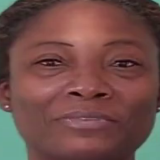

In [167]:
src.valid[19]

In [156]:
fnames[0].stem

'aagfhgtpmv'

In [178]:
%%time
data = (src.label_from_func(lambda o: _dict_fname2label[o.stem]))
#        .databunch(bs).normalize(imagenet_stats))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.42 ms


In [179]:
data = data.databunch(bs, num_workers=0)

TypeError: expected str, bytes or os.PathLike object, not int

In [79]:
#%%time
#src = (FaceVideoList.from_df(annots, path=SOURCE, cols='fname', resize=.5)
#       .split_by_rand_pct())

CPU times: user 128 ms, sys: 12 ms, total: 140 ms
Wall time: 43.9 ms


In [152]:
src.train[34]

(Image (3, 160, 160), Category FAKE)

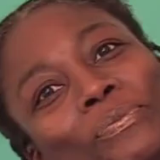

In [83]:
src.train[1]

In [154]:
bs, size = 32, 128

In [86]:
%%time
src.

CPU times: user 34 s, sys: 3.48 s, total: 37.5 s
Wall time: 6.87 s


In [63]:
%%time
data = (src.label_from_df('label')
        .databunch(bs=bs, num_workers=4).normalize(imagenet_stats))  #num_workers=0 required on laptop for me

You can deactivate this warning by passing `no_check=True`.
CPU times: user 8min 39s, sys: 56.3 s, total: 9min 35s
Wall time: 1min 47s


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/fastai/basic_data.py:262: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in self.train_ds: 194,303,198,195
  warn(warn_msg)


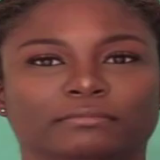

In [65]:
data.train_ds.x[199]

In [150]:
%%time
next(iter(data.train_dl))

CPU times: user 31.1 s, sys: 5.44 s, total: 36.5 s
Wall time: 27.8 s


(tensor([[[[-0.4226, -0.6965, -0.7308,  ...,  0.6221,  0.6221,  0.6221],
           [-0.5938, -0.6452, -0.6623,  ...,  0.5878,  0.5878,  0.5878],
           [-0.6452, -0.6281, -0.6281,  ...,  0.5536,  0.5536,  0.5536],
           ...,
           [-0.8849, -0.8849, -0.9192,  ..., -1.1760, -1.1589, -1.1247],
           [-0.8849, -0.8849, -0.9192,  ..., -1.1589, -1.1418, -1.1247],
           [-0.8849, -0.8849, -0.9020,  ..., -1.1247, -1.1247, -1.0904]],
 
          [[-0.5826, -0.8627, -0.8627,  ...,  0.5553,  0.5553,  0.5553],
           [-0.7577, -0.8102, -0.7927,  ...,  0.5378,  0.5378,  0.5378],
           [-0.8102, -0.7927, -0.7577,  ...,  0.5378,  0.5378,  0.5378],
           ...,
           [-1.2479, -1.2479, -1.2479,  ..., -1.4405, -1.4230, -1.3880],
           [-1.2479, -1.2479, -1.2479,  ..., -1.4405, -1.4055, -1.3880],
           [-1.2479, -1.2479, -1.2304,  ..., -1.4230, -1.4230, -1.3880]],
 
          [[-0.6018, -0.8807, -0.8981,  ...,  0.6879,  0.6879,  0.6879],
           [-

CPU times: user 32.2 s, sys: 5.69 s, total: 37.9 s
Wall time: 30 s


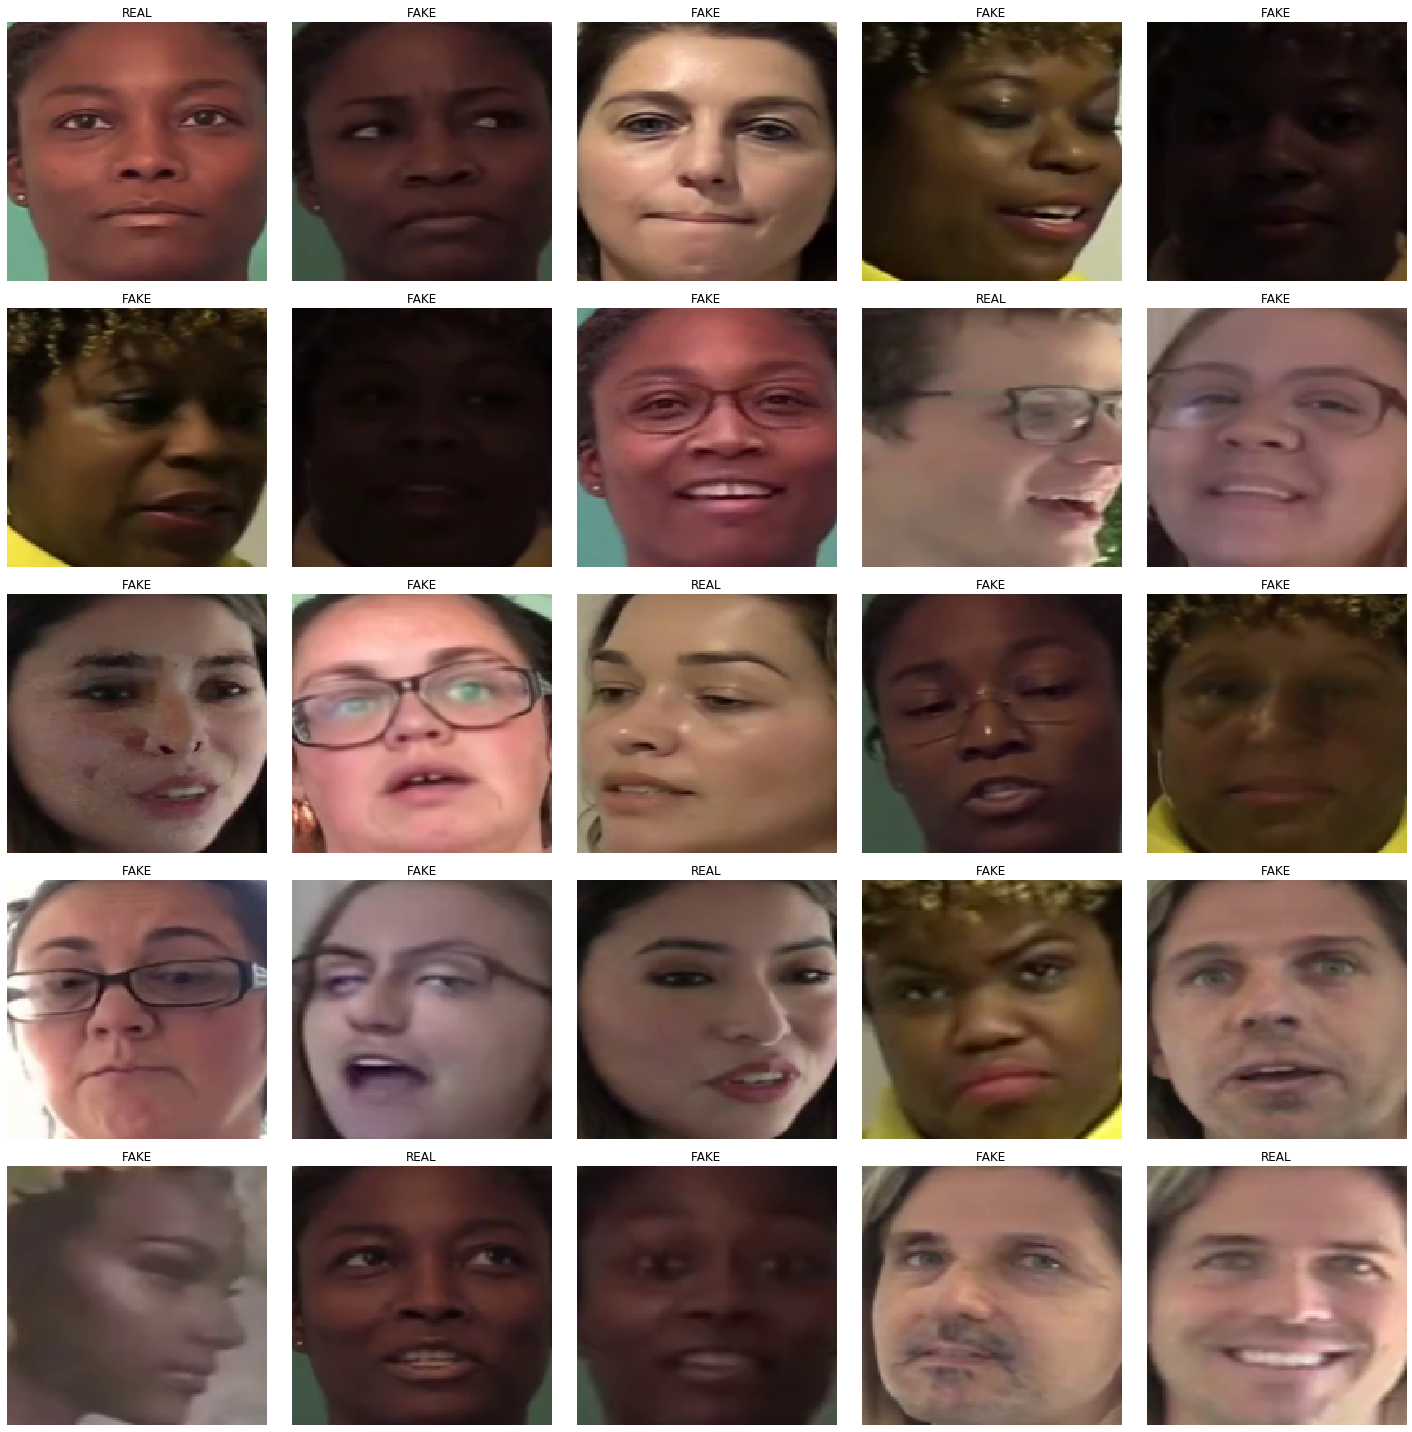

In [151]:
%%time
data.show_batch()

In [152]:
net=MesoNet()

In [153]:
learn = Learner(data, MesoNet(), metrics=accuracy)

In [154]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 